In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, CuDNNLSTM, Dropout, Activation
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datetime import datetime
from tensorflow.keras.models import load_model
from sklearn.metrics import r2_score

### Obtaining the raw data

In [2]:
df            = pd.read_csv('downloaded_data.csv')
required_cols = ['fb_datetime', 'location_label', 'cases',
                 'population', 'cases_per_100k', 'bundesland_name']

In [3]:
df              = df[required_cols]
df              = df[df.fb_datetime.notnull()]
date            = df.fb_datetime.map(lambda str_date: datetime.fromisoformat(str_date))
df['date']      = date
only_date       = df.fb_datetime.map(lambda x: (str(x)).split(" ")[0]).map(lambda str_date: datetime.fromisoformat(str_date))
df['only_date'] = only_date

In [4]:
df = df.sort_values(by='date')
df = df.groupby(['location_label', 'only_date']).tail(1)
del df['fb_datetime']
del df['only_date']

### Label Encoding the data

In [5]:
# We need 2 label encoders (location_label, bundesland_name)
lab_enc_location   = LabelEncoder()
lab_enc_bundesland = LabelEncoder()

In [6]:
df['location_label']  = lab_enc_location.fit_transform(df['location_label'].astype('str'))
df['bundesland_name'] = lab_enc_bundesland.fit_transform(df['bundesland_name'].astype('str'))

### Scaling the data

In [7]:
# We need 3 scalers (cases, population, cases_per_100k)
cases_scaler      = MinMaxScaler()
population_scaler = MinMaxScaler()
cases100k_scaler  = MinMaxScaler()

In [8]:
cases      = df.cases.values
population = df.population.values
cases_100k = df.cases_per_100k.values

In [9]:
cases      = cases.reshape(-1,1)
population = population.reshape(-1,1)
cases_100k = cases_100k.reshape(-1,1)

In [10]:
scaled_cases      = cases_scaler.fit_transform(cases)
scaled_population = population_scaler.fit_transform(population)
scaled_cases100k  = cases100k_scaler.fit_transform(cases_100k)

In [11]:
df['population']     = scaled_population
df['cases_per_100k'] = scaled_cases100k
df['cases']          = scaled_cases

### Get data to be fed to model

In [12]:
# Based on last week's data, what's the status of COVID in next 7 days gonna be?
# We will predict the mean number of COVID cases in next 7 days in a location.
past_win_size   = 7
future_win_size = 7

In [13]:
locations = list(df.location_label.unique())

In [14]:
loc_seq_data = [df[df.location_label==location].sort_values(by=['date'])
                   for location in locations]

In [15]:
X = []
y = []

In [16]:
for data in loc_seq_data:
    
    del data['date']
    
    vals        = data.values
    cases_index = data.columns.get_loc('cases')
    
    for pointer in range(past_win_size, len(vals)-future_win_size):
        
        X.append(vals[pointer-past_win_size:pointer, :])
        future_mean_covid_cases = np.mean(vals[pointer:pointer+future_win_size, cases_index])
        y.append(future_mean_covid_cases)
        
X = np.array(X)
y = np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True)

In [18]:
# No. of training samples
X_train.shape[0]

3790

In [19]:
# No. of testing samples
X_test.shape[0]

422

### The LSTM model

In [20]:
regressor = Sequential()

# 1st layer
regressor.add(CuDNNLSTM(128, 
                        return_sequences  =True, 
                        input_shape       =(X_train.shape[1], X_train.shape[2]), 
                        kernel_initializer='random_normal'))

#regressor.add(Activation('softmax'))

# 2nd layer
regressor.add(Dropout(0.2))

# 3rd layer
regressor.add(CuDNNLSTM(128, 
                        return_sequences  =True,
                        kernel_initializer='random_normal'))
#regressor.add(Activation('softmax'))

# 4th layer
regressor.add(Dropout(0.2))

# 5th layer
regressor.add(CuDNNLSTM(128, 
                        return_sequences  =True,
                        kernel_initializer='random_normal'))
#regressor.add(Activation('softmax'))

# 6th layer
regressor.add(Dropout(0.2))

# 7th layer
regressor.add(CuDNNLSTM(128,
                        kernel_initializer='random_normal'))
#regressor.add(Activation('softmax'))

# 8th layer
regressor.add(Dropout(0.2))

# 9th layer
regressor.add(Dense(1,
                   kernel_initializer='random_normal'))

W0419 01:21:53.270205 139694028830528 deprecation.py:506] From /home/somesh/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/keras/initializers.py:143: calling RandomNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [21]:
regressor.compile(optimizer='adam', loss='msle')

In [22]:
regressor.fit(X_train, y_train, epochs=100, batch_size=32, use_multiprocessing=True)

W0419 01:21:53.767110 139694028830528 deprecation.py:323] From /home/somesh/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
3790/3790 [==============================] - 3s 676us/sample - loss: 0.0036
Epoch 2/100
3790/3790 [==============================] - 1s 162us/sample - loss: 0.0034
Epoch 3/100
3790/3790 [==============================] - 1s 170us/sample - loss: 0.0034
Epoch 4/100
3790/3790 [==============================] - 1s 179us/sample - loss: 0.0034
Epoch 5/100
3790/3790 [==============================] - 1s 170us/sample - loss: 0.0033
Epoch 6/100
3790/3790 [==============================] - 1s 191us/sample - loss: 0.0030
Epoch 7/100
3790/3790 [==============================] - 1s 186us/sample - loss: 0.0027
Epoch 8/100
3790/3790 [==============================] - 1s 177us/sample - loss: 0.0023
Epoch 9/100
3790/3790 [==============================] - 1s 160us/sample - loss: 0.0028
Epoch 10/100
3790/3790 [==============================] - 1s 168us/sample - loss: 0.0035
Epoch 11/100
3790/3790 [==============================] - 1s 160us/sample - loss: 0.0031
Epoch 12/100
3790/3790 [======

3790/3790 [==============================] - 1s 219us/sample - loss: 2.3513e-04
Epoch 92/100
3790/3790 [==============================] - 1s 215us/sample - loss: 3.0697e-04
Epoch 93/100
3790/3790 [==============================] - 1s 207us/sample - loss: 2.7482e-04
Epoch 94/100
3790/3790 [==============================] - 1s 199us/sample - loss: 3.6766e-04
Epoch 95/100
3790/3790 [==============================] - 1s 204us/sample - loss: 2.2753e-04
Epoch 96/100
3790/3790 [==============================] - 1s 209us/sample - loss: 2.1672e-04
Epoch 97/100
3790/3790 [==============================] - 1s 220us/sample - loss: 2.1030e-04
Epoch 98/100
3790/3790 [==============================] - 1s 213us/sample - loss: 1.9902e-04
Epoch 99/100
3790/3790 [==============================] - 1s 196us/sample - loss: 2.0480e-04
Epoch 100/100
3790/3790 [==============================] - 1s 201us/sample - loss: 2.4167e-04


In [23]:
# regressor.save('my_model.h5')

In [24]:
loaded_regressor = load_model('my_model.h5')

W0419 01:23:07.833707 139694028830528 deprecation.py:506] From /home/somesh/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling Orthogonal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0419 01:23:07.834666 139694028830528 deprecation.py:506] From /home/somesh/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Obtaining the predictions

In [25]:
predictions          = loaded_regressor.predict(X_test)
actual_values        = y_test.reshape(-1, 1)
predicted_mean_covid = cases_scaler.inverse_transform(predictions)
actual_mean_covid    = cases_scaler.inverse_transform(actual_values)

### Obtaining the accuracy

In [26]:
r2_score(actual_mean_covid, predicted_mean_covid)

0.9266377153715646

### Plot of actual weekly mean number of covid cases vs predicted weekly mean number of covid cases

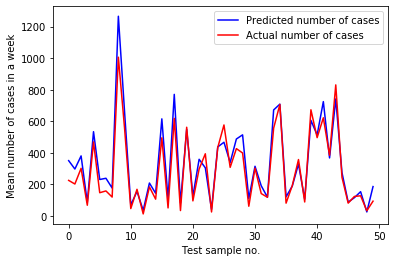

In [33]:
plt.plot(predicted_mean_covid[:50], color='blue', label='Predicted number of cases')
plt.plot(actual_mean_covid[:50], color='red', label='Actual number of cases')
plt.xlabel("Test sample no.")
plt.ylabel("Mean number of cases in a week")
plt.legend()
plt.show()

### Find the mean number of covid cases in an area in the next few days based on the data of past few days
 - We can use the API to get past data.
 - For simplicity I am using already downloaded sample data
 - I will do some filtering to obtain the data of given area for the last 7 days.
 - Then I will feed this data to a function, that will give me the result.

In [28]:
# Pick any area from the list
pd.set_option('display.max_rows', 500)
x = pd.read_csv('downloaded_data.csv')
pd.DataFrame(x['location_label'].unique())

,0
0,Segeberg
1,Schleswig-Flensburg
2,Dithmarschen
3,Steinburg
4,Plön
5,Rendsburg-Eckernförde
6,Pinneberg
7,Flensburg
8,Lübeck
9,Herzogtum Lauenburg


In [29]:
area_name = 'Darmstadt'

In [30]:
sample_data              = pd.read_csv('downloaded_data.csv')
sample_data              = sample_data[sample_data.location_label==area_name]
sample_data              = sample_data[required_cols]
sample_data              = sample_data[sample_data.fb_datetime.notnull()]
date                     = sample_data.fb_datetime.map(lambda str_date: datetime.fromisoformat(str_date))
only_date                = sample_data.fb_datetime.map(lambda x: (str(x)).split(" ")[0]).map(lambda str_date: datetime.fromisoformat(str_date))
sample_data['date']      = date
sample_data['only_date'] = only_date
sample_data              = sample_data.sort_values(by='date')
sample_data              = sample_data.groupby(['only_date']).tail(1)
latest_data              = sample_data.tail(n=7)
del latest_data['fb_datetime']
del latest_data['only_date']



def get_result(df):
    df['location_label']  = lab_enc_location.transform(df['location_label'].astype('str'))
    df['bundesland_name'] = lab_enc_bundesland.transform(df['bundesland_name'].astype('str'))
    cases                 = df.cases.values
    population            = df.population.values
    cases_100k            = df.cases_per_100k.values
    cases                 = cases.reshape(-1,1)
    population            = population.reshape(-1,1)
    cases_100k            = cases_100k.reshape(-1,1)
    scaled_cases          = cases_scaler.transform(cases)
    scaled_population     = population_scaler.transform(population)
    scaled_cases100k      = cases100k_scaler.transform(cases_100k)
    df['population']      = scaled_population
    df['cases_per_100k']  = scaled_cases100k
    df['cases']           = scaled_cases
    
    del df['date']
    vals = df.values
    X    = []
    
    for pointer in range(past_win_size, len(vals)-future_win_size):
        
        X.append(vals[pointer-past_win_size:pointer, :])

    X = np.array(df.values)
    X = np.reshape(X, (1, X.shape[0], X.shape[1]))
    
    prediction           = loaded_regressor.predict(X)
    predicted_mean_covid = cases_scaler.inverse_transform(prediction)
    
    return int(predicted_mean_covid[0][0])



future_number = get_result(latest_data)
latest_number = sample_data.tail(n=1).cases.values[0]

/home/somesh/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/somesh/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/somesh/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [31]:
latest_number

133

In [32]:
future_number

154